In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model_lite as modellib
%matplotlib inline 

# np.set_printoptions(threshold=np.nan)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# MS COCO Dataset
import coco
config = coco.CocoConfig()
COCO_DIR = "/home/michael/Desktop/github/Mask_RCNN/samples/dataset"  # TODO: enter value here

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

/home/michael/anaconda3/envs/nv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

Using TensorFlow backend.


In [2]:
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "minival")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(model_dir=MODEL_DIR,config=config)

weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
Images: 4952
Classes: ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
1024 1024
Tensor("fpn_p2/Bi

image ID: coco.451084 (322) http://cocodataset.org/#explore?id=451084
[[  0   8]
 [  0  18]
 [  0  19]
 ...
 [  0 894]
 [  0 899]
 [  0 976]]


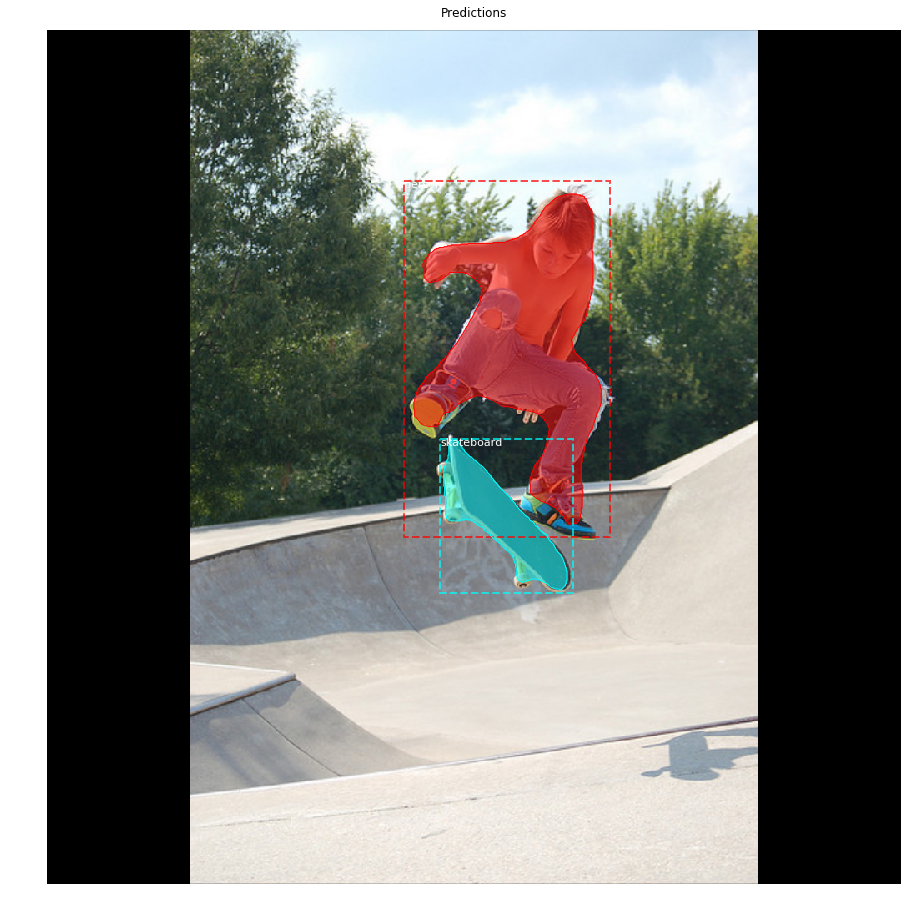

In [3]:
image_id = 322
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image])

# Display results
ax = get_ax(1)
r = results[0][0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

[[  0   8]
 [  0  18]
 [  0  19]
 ...
 [  0 894]
 [  0 899]
 [  0 976]]


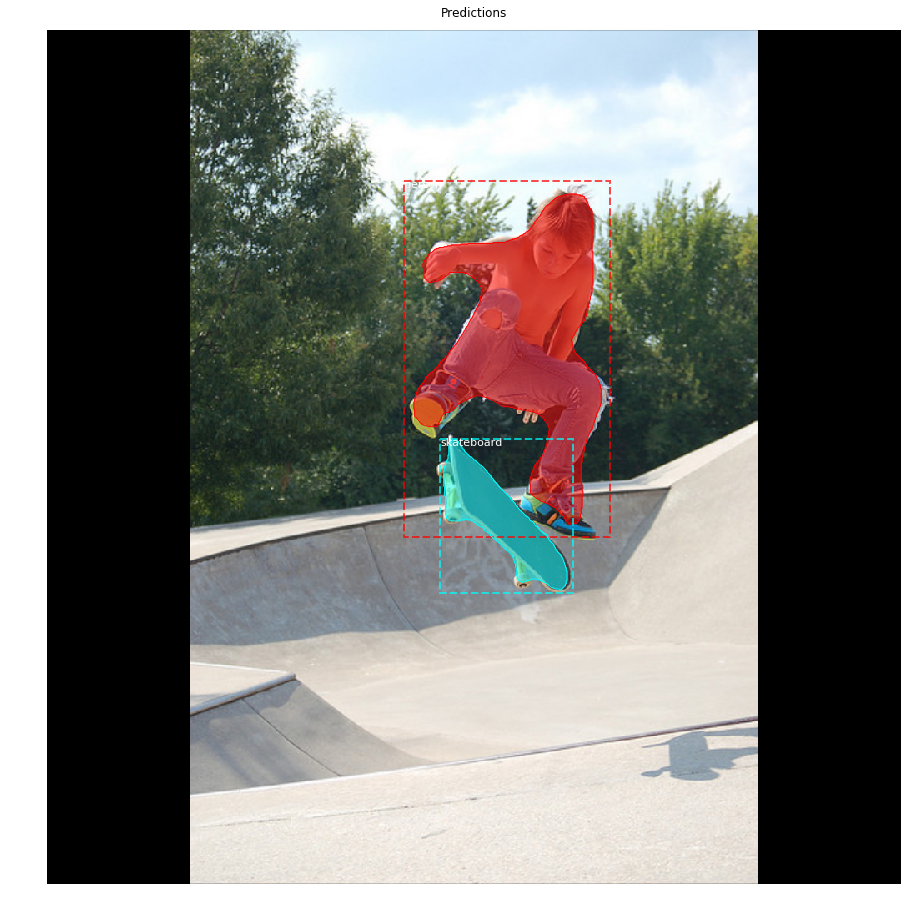

In [4]:
# original mrcnn_class and mrcnn_class_logits
align = results[2]

rois_touse = results[1]

# Run object detection
results2 = model.detect_shortcut([image], rois_touse)

# Display results
ax = get_ax(1)
r = results2[0][0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")


In [5]:
rois_used = results2[1]
align2 = results2[2]
p1 = results[3]
p2 = results2[3]

In [6]:
np.array_equal(rois_touse,rois_used)

True

In [7]:
np.array_equal(align,align2)

True

In [8]:
np.array_equal(p1, p2)

True

In [9]:
p1

array([[[[3.4442644e+00, 0.0000000e+00, 2.4060333e+00, ...,
          6.0955567e+00, 1.5044365e+00, 0.0000000e+00],
         [2.0765138e+00, 2.1127980e+00, 4.3246398e+00, ...,
          3.5303512e+00, 1.5947133e+00, 0.0000000e+00],
         [3.2673652e+00, 2.8140438e+00, 1.8237579e+00, ...,
          5.2973390e-01, 1.5382625e+00, 0.0000000e+00],
         ...,
         [2.7196846e+00, 3.0659285e+00, 2.3281884e+00, ...,
          2.9314165e+00, 2.0917146e+00, 0.0000000e+00],
         [0.0000000e+00, 3.4450157e+00, 5.7432251e+00, ...,
          0.0000000e+00, 1.7668574e+00, 0.0000000e+00],
         [0.0000000e+00, 5.6811628e+00, 4.7598743e+00, ...,
          4.9278796e-02, 2.6956880e+00, 1.3964307e-01]],

        [[8.7194324e-01, 0.0000000e+00, 1.8343716e+00, ...,
          3.4820404e+00, 2.2955866e+00, 0.0000000e+00],
         [9.4666886e-01, 2.4449310e-01, 4.4539328e+00, ...,
          8.7099493e-02, 2.4195969e+00, 0.0000000e+00],
         [2.1979213e+00, 5.4068553e-01, 1.8681886e+00, .

In [10]:
p2

array([[[[3.4442644e+00, 0.0000000e+00, 2.4060333e+00, ...,
          6.0955567e+00, 1.5044365e+00, 0.0000000e+00],
         [2.0765138e+00, 2.1127980e+00, 4.3246398e+00, ...,
          3.5303512e+00, 1.5947133e+00, 0.0000000e+00],
         [3.2673652e+00, 2.8140438e+00, 1.8237579e+00, ...,
          5.2973390e-01, 1.5382625e+00, 0.0000000e+00],
         ...,
         [2.7196846e+00, 3.0659285e+00, 2.3281884e+00, ...,
          2.9314165e+00, 2.0917146e+00, 0.0000000e+00],
         [0.0000000e+00, 3.4450157e+00, 5.7432251e+00, ...,
          0.0000000e+00, 1.7668574e+00, 0.0000000e+00],
         [0.0000000e+00, 5.6811628e+00, 4.7598743e+00, ...,
          4.9278796e-02, 2.6956880e+00, 1.3964307e-01]],

        [[8.7194324e-01, 0.0000000e+00, 1.8343716e+00, ...,
          3.4820404e+00, 2.2955866e+00, 0.0000000e+00],
         [9.4666886e-01, 2.4449310e-01, 4.4539328e+00, ...,
          8.7099493e-02, 2.4195969e+00, 0.0000000e+00],
         [2.1979213e+00, 5.4068553e-01, 1.8681886e+00, .

In [11]:
# mod1 = model.model
# mod2 = model.model_shortcut

# l1 = mod1.get_layer("sfpn_c4p4")
# l2 = mod2.get_layer("")